# Install Libraries

In [36]:
#use the following line to install the required libraries if needed
#pip install '...'

#! pip install fairlearn
#! pip install dalex -U
#! pip install -U scikit-learn
#! pip install -U pandas
#! pip install -U aif360
!pip install --upgrade fairlearn plotly


# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import dalex as dx

from copy import copy

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

{
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": matplotlib.__version__,
    "seaborn": sns.__version__,
    "sklearn": sklearn.__version__,
    "dalex": dx.__version__,
}

{'numpy': '2.0.2',
 'pandas': '2.3.2',
 'matplotlib': '3.10.0',
 'seaborn': '0.13.2',
 'sklearn': '1.7.2',
 'dalex': '1.7.2'}

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
sklearn.set_config(display="diagram")

## Bias a priori

*When implementing an AI system, fairness and biases must be an important component during conception, especially when dealing with sensitive information, and/or Personally Identifiable Information (PII), and/or Personal Health Information (PHI). Indeed, not only those information are bound to the law (e.g., GDPR in Europe), but they are also bound to a brand image challenge.*

Today's example aims at **assigning a risk with recruitment data**.

Before implementing any AI system to predict the likelihood of a candidate to be hired, **AI engineers AND business stakeholders** should:

- Sit and identify potential sources of biases
- Define one or several metrics that will quantify the bias of the AI system

![fairness_tree](../../images/fairness_tree.png)

## Dataset

StackOverflow's annual user-generated survey (over 70,000 responses from over 180 countries) of developers examines all aspects of the developer experience, from learning code to preferred technologies, version control and work experience.

From the survey results, we have built a dataset with the following columns:
- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)*
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)*
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)*
- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*
- **PreviousSalary**: the applicant's previous job salary *(float)*
- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*


In [6]:
df = pd.read_csv("/content/stackoverflow_full.csv", index_col=0)
target = "Employed"

## Exploratory Data Analysis

#### Visualization of data columns

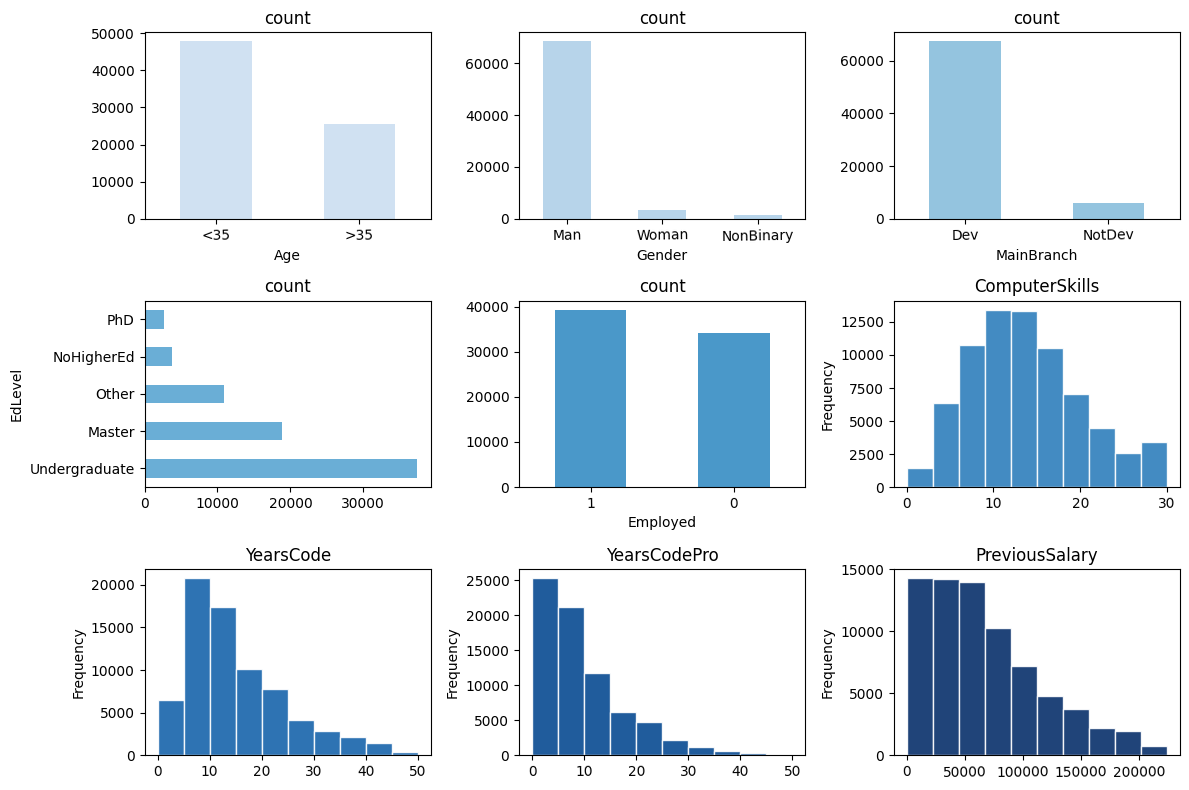

In [7]:
cmap = matplotlib.cm.Blues  # each subplot has its own blue color

fig, ax = plt.subplots(3,3, figsize=(12,8))

# Age
_ = df.Age.value_counts().plot.bar(subplots=True,
                                   ax=ax[0, 0],
                                   rot=1,
                                   color=cmap(0.2))
# Gender
_ = df.Gender.value_counts().plot.bar(subplots=True,
                                      ax=ax[0, 1],
                                      rot=1,
                                      color=cmap(0.3))
# MainBranch
_ = df.MainBranch.value_counts().plot.bar(subplots=True,
                                          ax=ax[0, 2],
                                          rot=1,
                                          color=cmap(0.4))
# EdLevel
_ = df.EdLevel.value_counts().plot.barh(subplots=True,
                                        ax=ax[1, 0],
                                        color=cmap(0.5))

# Employed
_ = df.Employed.value_counts().plot.bar(subplots=True,
                                        ax=ax[1, 1],
                                        rot=1,
                                        color=cmap(0.6))

# ComputerSkills
_ = df.ComputerSkills.clip(None, 30).plot.hist(subplots=True,
                                               ax= ax[1, 2],
                                               rot=1,
                                               color=cmap(0.7),
                                               alpha=0.9,
                                               edgecolor='w')

ax[1, 2].title.set_text('ComputerSkills')

# YearsCode
_ = df.YearsCode.plot.hist(subplots=True,
                                ax= ax[2, 0],
                                rot=1,
                                color=cmap(0.8),
                                alpha=0.9,
                                edgecolor='w')

ax[2, 0].title.set_text('YearsCode')

# YearsCodePro
_ = df.YearsCodePro.plot.hist(subplots=True,
                              ax= ax[2, 1],
                              rot=1,
                              color=cmap(0.9),
                              alpha=0.9,
                              edgecolor='w')

ax[2, 1].title.set_text('YearsCodePro')

# PreviousSalary
_ = df.PreviousSalary.plot.hist(subplots=True,
                                ax= ax[2, 2],
                                rot=1,
                                color=cmap(1.0),
                                alpha=0.9,
                                edgecolor='w')

ax[2, 2].title.set_text('PreviousSalary')

fig.tight_layout()

#### Visualization of outliers

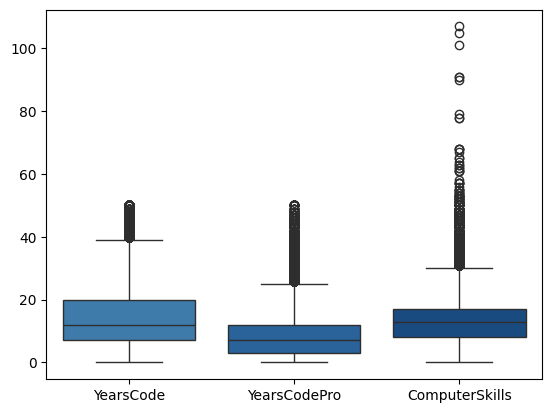

In [8]:
sns.boxplot(data = df[["YearsCode", "YearsCodePro", "ComputerSkills"]], palette=[cmap(0.7), cmap(0.8), cmap(0.9)]);

/tmp/ipython-input-3523727398.py:1: UserWarning:

The palette list has more values (3) than needed (1), which may not be intended.



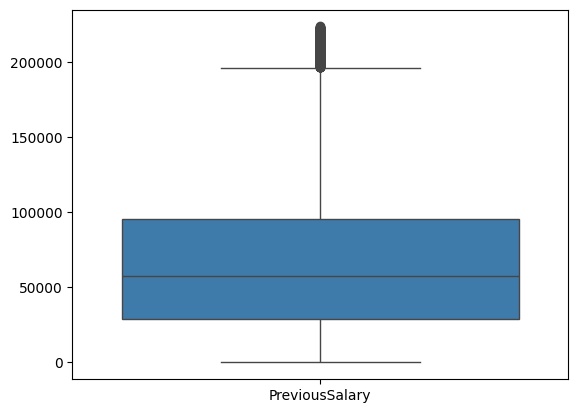

In [9]:
sns.boxplot(data = df[["PreviousSalary"]], palette=[cmap(0.7), cmap(0.8), cmap(0.9)]);

#### Visualization of bias on Employed

After analysing the graphs above, what bias can you identify ?

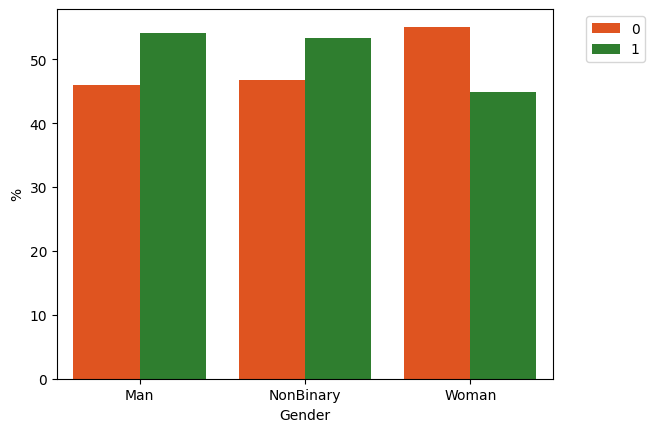

In [10]:
var = (df
 .groupby("Gender")[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .rename("%")
 .reset_index()
)

ax = sns.barplot(data=var, ci=None, x="Gender", y="%", hue="Employed", palette=["orangered", "forestgreen"])
ax.legend(bbox_to_anchor=(1.2, 1.0))

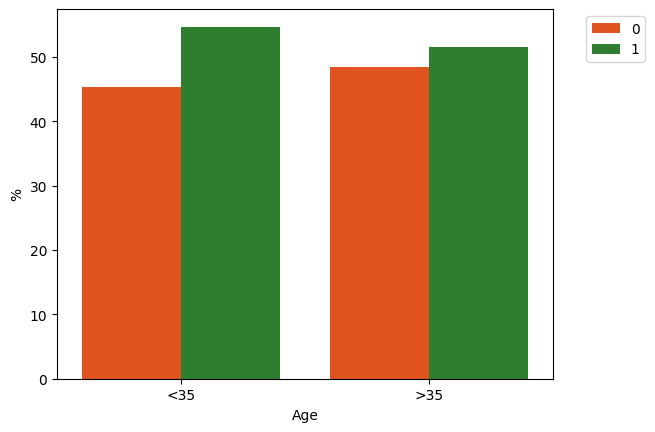

In [11]:
var = (df
 .groupby("Age")[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .rename("%")
 .reset_index()
)

ax = sns.barplot(data=var, ci=None, x="Age", y="%", hue="Employed", palette=["orangered", "forestgreen"])
ax.legend(bbox_to_anchor=(1.2, 1.0))

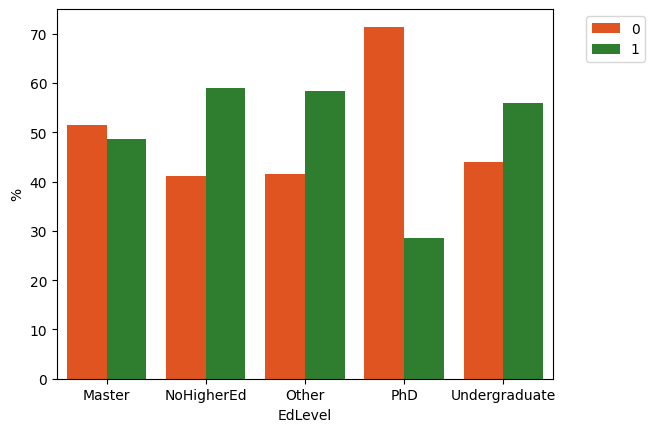

In [12]:
var = (df
 .groupby("EdLevel")[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .rename("%")
 .reset_index()
)

ax = sns.barplot(data=var, ci=None, x="EdLevel", y="%", hue="Employed", palette=["orangered", "forestgreen"])
ax.legend(bbox_to_anchor=(1.2, 1.0))

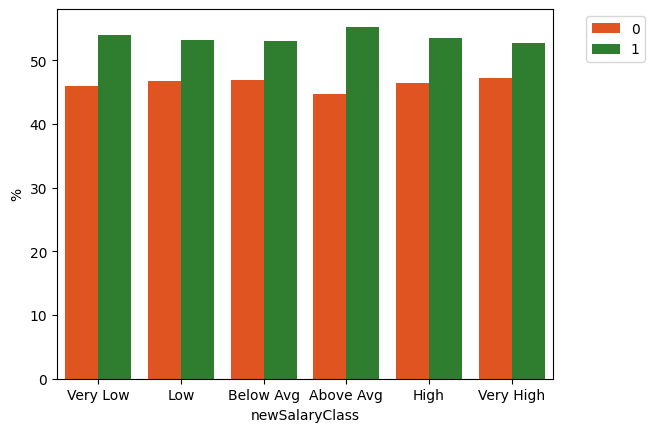

In [13]:
df1 = df.copy()
df1["newSalaryClass"], bins = pd.cut(df["PreviousSalary"], 6, retbins=True, labels=["Very Low", "Low", "Below Avg", "Above Avg", "High", "Very High"])

var = (df1
 .groupby("newSalaryClass")[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .rename("%")
 .reset_index()
)


# Plot
ax = sns.barplot(data=var, ci=None, x="newSalaryClass", y="%", hue="Employed", palette=["orangered", "forestgreen"])
ax.legend(bbox_to_anchor=(1.2, 1.0))

If you have identify more than one bias. Could you analyse the cross-bias ?

#### Analytics on biases for Gender and Age


You were able to visualize the bias above. Now make a quick quantitative analysis of the identified bias (don't forget the cross analysis).

In [14]:
df["Gender"].value_counts()

,count
Gender,
Man,68573
Woman,3518
NonBinary,1371


In [15]:
(df
 .groupby("Gender")[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .to_frame()
)

proportion
Gender    Employed            
Man       1               54.1
          0               45.9
NonBinary 1               53.3
          0               46.7
Woman     0               55.1
          1               44.9

In [16]:
pd.crosstab(df["Age"], df["Employed"])

Employed,0,1
Age,,
<35,21649,26170
>35,12421,13222


In [17]:
(df
 .groupby(["Age", "Gender"])[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .to_frame()
)

proportion
Age Gender    Employed            
<35 Man       1               55.2
              0               44.8
    NonBinary 1               56.0
              0               44.0
    Woman     0               53.7
              1               46.3
>35 Man       1               52.0
              0               48.0
    NonBinary 0               51.8
              1               48.2
    Woman     0               59.0
              1               41.0

In [18]:
(df
 .groupby(["Age", "EdLevel"])[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .to_frame()
)

proportion
Age EdLevel       Employed            
<35 Master        0               52.0
                  1               48.0
    NoHigherEd    1               60.6
                  0               39.4
    Other         1               60.3
                  0               39.7
    PhD           0               71.6
                  1               28.4
    Undergraduate 1               56.6
                  0               43.4
>35 Master        0               50.5
                  1               49.5
    NoHigherEd    1               54.5
                  0               45.5
    Other         1               55.7
                  0               44.3
    PhD           0               71.2
                  1               28.8
    Undergraduate 1               54.6
                  0               45.4

In [19]:
pd.crosstab(df1["newSalaryClass"], df1["Employed"])

Employed,0,1
newSalaryClass,,
Very Low,10822,12684
Low,10659,12128
Below Avg,6437,7261
Above Avg,3115,3854
High,2078,2391
Very High,959,1074


**Quick EDA**

If we bin by bias1, we realize that :
- Under represented in volume: xxx vs. yyy   
- Biased from an employment perspective: zzz% vs. www%


**Conclusion: the a priori looks confirmed and will need to be carefully handled during modelling.**

----

**Notes**

1. This is a toy example where biases are "straightforward" and well identified as "recurrent" social biases. However, it might not always be as easy to detect them. Additional sources might come from data history, selection bias, data incompleteness, unexpected sources of bias (column/attribute), ...
2. In this example, we identified biases related to representation in volume. If we had not been exposed to such discrepencies, namely having a balanced dataset, could we have concluded that biases would have been limited while modelling? Not so sure, see [this article](https://arxiv.org/pdf/1811.08489.pdf).

In [20]:
#split your data set in 2 parts : training and testing

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target),
    df[target],
    test_size=0.3,
    random_state=42
)

## ML prerequisites

## Modeling


##### Fairness evaluation principles

The main object of dalex is the `Explainer` container which wraps a **dataset** (features and target) and a **trained model**.

Once the data and the model have been wrapped, one needs to fix **protected and privileged attributes**.

**Important note**: beware these choices correspond to an a priori understanding of the problem and could miss hidden flaws of the model. An interesting line of work would consist in conducting a kind of grid-search exploration for potential biases.

In [21]:
# Protected attribute is 0 if a man or non binary and 0 if a woman plus the age

protected = (pd.Series(np.where(X_test["Gender"] == "Woman", '1', '0'), index=X_test.index)
             + '_'
             + X_test.Age)
protected_train = (pd.Series(np.where(X_train["Gender"] == "Woman", '1', '0').astype(str), index=X_train.index)
                   + '_'
                   + X_train.Age)

# Privileged population is men under 35 years old
privileged = '0_<35'

### Running model with no changes

#### Training

We chose to use decision trees as the classifier for this project. However, feel free to
- Change hyperparameters of the decision tree (typically, its depth) to optimize the accuracy and investigate whether there is a tradeoff between accuracy and fairness.
- Try other classifiers such as random forests.


In [22]:
preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
)

#You can change the Decision tree hyperparameters or the classifier below

clf_decisiontree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=123))
])

In [23]:
# clf_decisiontree.fit(df.drop(columns=[target]), df[target])
clf_decisiontree.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('passthrough', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
# exp_decisiontree = dx.Explainer(clf_decisiontree, df.drop(columns=[target]), df[target], verbose=False)
exp_decisiontree = dx.Explainer(clf_decisiontree, X_test, y_test, verbose=True)

Preparation of a new explainer is initiated

  -> data              : 22039 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 22039 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7829073c89a0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.536, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.000922, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


#### Algorithmic performance

In [25]:
exp_decisiontree.model_performance().result

,recall,precision,f1,accuracy,auc
DecisionTreeClassifier,0.804868,0.788158,0.796425,0.779845,0.860599


#### Fairness performance

Quoting Dalex' tutorial:


> The idea is that ratios between scores of privileged and unprivileged metrics should be close to 1. The closer, the fairer. To relax this criterion a little bit, it can be written more thoughtfully:

> $$ \forall i \in \{a, b, ..., z\}, \quad \epsilon < \frac{metric_i}{metric_{privileged}} < \frac{1}{\epsilon}.$$

> Where the epsilon is a value between 0 and 1, it should be a minimum acceptable value of the ratio. On default, it is 0.8, which adheres to four-fifths rule (80% rule) often looked at in hiring, for example.
"

##### Metrics used

Description of the metrics used for the fairness performance evaluation of each strategys:



- **Equal opportunity ratio** computed from True positive rate (recall)

> This number describes the proportions of correctly classified positive instances.

> $TPR = \frac{TP}{P}$

- **Predictive parity ratio** computed from Positive predicted value (precision)

> This number describes the ratio of samples which were correctly classified as positive from all the positive predictions.

> $PPV = \frac{TP}{TP + FP}$

- **Accuracy equality ratio** computed from Accuracy

> This number is the ratio of the correctly classified instances (positive and negative) of all decisions.

> $ACC = \frac{TP + TN}{TP + FP + TN + FN}$

- **Predictive equality ratio** computed from False positive rate

> This number describes the share the proportion of actual negatives which was falsely classified as positive.

> $FPR = \frac{FP}{TP + TN}$

- **Statistical parity ratio** computed from Positive rate

> This number is the overall rate of positively classified instances, including both correct and incorrect decisions.

> $PR = \frac{TP + FP}{TP + FP + TN + FN}$

**Notes**:
1. Fairness metrics work the exact same way as performance metrics do. If one was to fit a model on the entire dataset and foster overfitting (namely, skipping a `train_test_split` operation), she would end up with a non biased model.
2. A lots of metrics can be computed. It is important to define early in the conception which are the critical metrics to monitor

The method `model_fairness` returns a fairness object from which fairness evaluations can be conducted. Notice that every metrics inherited from the confusion matrix are computed during the instantiation.

Two methods can then be performed:
- The `fairness_check` method, which returns a report on the fairness of the model. It requires an epsilon parameter that corresponds to the threshold ratio below which a given metric is considered to be unfair (default value is 0.8).
- The `plot` method, which allows to visualize the main fairness ratios between the protected subgroups and the privileged one.

In [26]:
fairness_decisiontree = exp_decisiontree.model_fairness(protected=protected, privileged=privileged)

In [27]:
fairness_decisiontree.fairness_check(epsilon = 0.8) # default epsilon

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '0_<35'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
            TPR       ACC       PPV       FPR       STP
0_>35  0.969325  0.989770  0.982346  0.942085  0.937943
1_<35  0.947239  1.006394  0.979823  0.768340  0.833333
1_>35  0.900613  1.046036  1.034048  0.459459  0.673759


In [42]:
fairness_decisiontree.plot(verbose=False)

ValueError: Invalid property specified for object of type plotly.graph_objs.Layout: 'titlefont'

Did you mean "title"?

    Valid properties:
        activeselection
            :class:`plotly.graph_objects.layout.Activeselection`
            instance or dict with compatible properties
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. This is the default
            value; however it could be overridden for individual
            axes.
        barcornerradius
            Sets the rounding of bar corners. May be an integer
            number of pixels, or a percentage of bar width (as a
            string ending in %).
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to reduce
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        computed
            Placeholder for exporting automargin-impacting values
            namely `margin.t`, `margin.b`, `margin.l` and
            `margin.r` in "full-json" mode.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendiciclecolors
            If `true`, the icicle slice colors (whether given by
            `iciclecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to reduce "opacity" to
            see multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            `hiddenlabels`.
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled.
        hoversubplots
            Determines expansion of hover effects to other subplots
            If "single" just the axis pair of the primary point is
            included without overlaying subplots. If "overlaying"
            all subplots using the main axis and occupying the same
            space are included. If "axis", also include stacked
            subplots using the same axis when `hovermode` is set to
            "x", *x unified*, "y" or *y unified*.
        iciclecolorway
            Sets the default icicle slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendiciclecolors`.
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        map
            :class:`plotly.graph_objects.layout.Map` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        minreducedheight
            Minimum height of the plot with margin.automargin
            applied (in px)
        minreducedwidth
            Minimum width of the plot with margin.automargin
            applied (in px)
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newselection
            :class:`plotly.graph_objects.layout.Newselection`
            instance or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        scattergap
            Sets the gap (in plot fraction) between scatter points
            of adjacent location coordinates. Defaults to `bargap`.
        scattermode
            Determines how scatter points at the same location
            coordinate are displayed on the graph. With "group",
            the scatter points are plotted next to one another
            centered around the shared location. With "overlay",
            the scatter points are plotted over one another, you
            might need to reduce "opacity" to see multiple scatter
            points.
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        selections
            A tuple of
            :class:`plotly.graph_objects.layout.Selection`
            instances or dicts with compatible properties
        selectiondefaults
            When used in a template (as
            layout.template.layout.selectiondefaults), sets the
            default property values to use for elements of
            layout.selections
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        smith
            :class:`plotly.graph_objects.layout.Smith` instance or
            dict with compatible properties
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to reduce "opacity" to see
            multiple bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        
Did you mean "title"?

Bad property path:
titlefont
^^^^^^^^^

What can you tell from these fairness evaluation results?

## Strategy choice


After the data exploration, and the cognition of the bias, you should choose which strategy to implement to mitigate the bias.
Can you think of a strategy ?

You can call your supervisor to discuss about your idea and start the second part of this challenge.

For the selected strategy, you will have to follow the related part of the code to apply the solution and to measure the algorithmic and fairness performance of this solution.
Based on the result, you will decide to choose the solution or not, based on :
- Its algorithmic performance
- Its fairness score
- Your interpretation of these metrics and additional solution you can think of based on those
- Its economic benefit / loss fot the company


#### RandomForest approach : RandomForest without changing the dataset, nor privileged classes

In [43]:
# RandomForest approach : RandomForest without changing the dataset, nor privileged classes

from sklearn.ensemble import RandomForestClassifier

preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
)

#You can change the Decision tree hyperparameters or the classifier below

clf_randomforest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=10, random_state=123, n_estimators=200))
])

clf_randomforest.fit(X_train, y_train)
exp_randomforest = dx.Explainer(clf_randomforest, X_test, y_test, verbose=True)

exp_randomforest.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 22039 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 22039 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7829073c89a0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.468, mean = 0.537, max = 0.566
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.566, mean = -0.00209, max = 0.508
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.999406,0.541839,0.702701,0.547529,0.787965


In [44]:
fairness_randomforest = exp_randomforest.model_fairness(protected=protected, privileged=privileged)

In [45]:
fairness_randomforest.fairness_check(epsilon = 0.8) # default epsilon

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on '0_<35'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
         TPR       ACC       PPV       FPR       STP
0_>35  0.999  0.985507  0.970909  0.957661  0.979920
1_<35  0.994  0.931159  0.896364  0.924395  0.957831
1_>35  1.000  0.923913  0.843636  0.857863  0.917671


In [ ]:
fairness_randomforest.plot(verbose=False)

####Approach 1 : DecisionTree with changing the datas(remove age and gender), but not privileged classes

In [46]:
# Approach 1 : DecisionTree with changing the dataset (remove age and gender), but not privileged classes
#split your data set in 2 parts : training and testing

toDrop = ['Employed', 'Age', 'Gender']
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    df.drop(columns=toDrop),
    df[target],
    test_size=0.3,
    random_state=42
)


preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
)

#You can change the Decision tree hyperparameters or the classifier below

clf_dt1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=123))
])

clf_dt1.fit(X_train1, y_train1)
exp_dt1 = dx.Explainer(clf_dt1, X_test1, y_test1, verbose=True)

exp_dt1.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 22039 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 22039 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7829073c89a0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.536, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.000785, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
DecisionTreeClassifier,0.800288,0.790104,0.795163,0.779391,0.860834


In [47]:
fairness_dt1 = exp_dt1.model_fairness(protected=protected, privileged=privileged, label='DecisionTreeClassifier_removeCols')

In [48]:
fairness_dt1.fairness_check(epsilon = 0.8) # default epsilon

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '0_<35'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
            TPR       ACC       PPV       FPR       STP
0_>35  0.953374  0.988491  0.991173  0.891892  0.914894
1_<35  0.943558  1.005115  0.978562  0.768340  0.831560
1_>35  0.890798  1.042199  1.031526  0.459459  0.668440


In [ ]:
fairness_dt1.plot(verbose=False)

####Approach 2 : DecisionTree with changing the dataset (remove age and gender), and resampling

In [49]:
# Approach 2 : DecisionTree with changing the dataset (remove age and gender), and resampling
#split your data set in 2 parts : training and testing

toDrop = ['Employed', 'Age', 'Gender']
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    df.drop(columns=toDrop),
    df[target],
    test_size=0.3,
    random_state=42
)

preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
)

#You can change the Decision tree hyperparameters or the classifier below

clf_dt1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=123))
])

clf_dt1.fit(X_train1, y_train1)

from dalex.fairness import resample
clf_resampled = copy(clf_dt1) # Create a copy to not alter the main object

# Resampling observations
indices_uniform = resample(protected_train, y_train1, verbose = False)

# Re-fit model with resampled data
clf_resampled.fit(X_train1.reset_index(drop=True).iloc[indices_uniform, :], y_train1.reset_index(drop=True)[indices_uniform])

exp_dt2 = dx.Explainer(clf_resampled, X_test1, y_test1, verbose=True)

exp_dt2.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 22039 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 22039 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7829073c89a0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.536, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.00104, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
DecisionTreeClassifier,0.808769,0.784357,0.796376,0.77871,0.860806


In [50]:
fairness_decisiontree_resampled = exp_dt2.model_fairness(
    protected, privileged, label='DecisionTreeClassifier_removeCols_resampled')

fairness_decisiontree_resampled.fairness_check(epsilon = 0.8)

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '0_<35'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
            TPR       ACC       PPV       FPR       STP
0_>35  0.986486  1.000000  0.987310  0.939623  0.950530
1_<35  0.966830  1.014139  0.978426  0.788679  0.851590
1_>35  0.921376  1.025707  0.975888  0.630189  0.731449


In [ ]:
fairness_dt1.plot([fairness_decisiontree_resampled])

#### Approach 3 : DecisionTree with changing the dataset (remove age and gender), resampling and postprocessing

In [51]:
# Approach 3 : DecisionTree with changing the dataset (remove age and gender), resampling and postprocessing
#split your data set in 2 parts : training and testing

diploma_map = {
    'NoHigherEd': 1,
    'Other': 2,
    'Undergraduate': 4,
    'Master': 6,
    'PhD': 8
}

"""df2 = df.copy()

df2['EdLevel'] = df2['EdLevel'].map(diploma_map)
df2['ExpScore'] = df2['YearsCode'] + 2*df2['YearsCodePro'] + 0.5*df2['EdLevel']
df2['ExpScore'] = 100*df2['ExpScore']/df2['ExpScore'].max()"""

toDrop = ['Employed', 'Age', 'Gender', 'YearsCode', 'EdLevel', 'PreviousSalary']
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    df.drop(columns=toDrop),
    df[target],
    test_size=0.3,
    random_state=42
)

preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
)

#You can change the Decision tree hyperparameters or the classifier below

clf_dt15 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=123))
])

clf_dt15.fit(X_train1, y_train1)

from dalex.fairness import resample, roc_pivot
clf_resampled1 = copy(clf_dt15) # Create a copy to not alter the main object

# Resampling observations
indices_uniform = resample(protected_train, y_train1, verbose = False)

# Re-fit model with resampled data
clf_resampled1.fit(X_train1.reset_index(drop=True).iloc[indices_uniform, :], y_train1.reset_index(drop=True)[indices_uniform])

exp_dt3 = dx.Explainer(clf_resampled1, X_test1, y_test1, verbose=True)

exp_decisiontree_roc1 = copy(exp_dt3)

# Results modifications. Theta arbitrarily set at 0.1
exp_decisiontree_roc1 = roc_pivot(exp_dt3, protected, privileged,
                                 theta = 0.033, verbose = False)

exp_decisiontree_roc1.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 22039 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 22039 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7829073c89a0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.537, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.00179, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
DecisionTreeClassifier,0.790112,0.794559,0.792329,0.778393,0.863856


In [52]:
fairness_decisiontree_roc1 = exp_decisiontree_roc1.model_fairness(
    protected,
    privileged,
    label='DecisionTreeClassifier_removeCols_resampled_roc_rem1')

fairness_decisiontree_roc1.fairness_check(epsilon = 0.8)

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '0_<35'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
            TPR       ACC       PPV       FPR       STP
0_>35  1.043646  1.000000  0.957921  1.156250  1.034026
1_<35  1.006418  1.005141  0.943069  0.982143  0.918715
1_>35  0.973042  1.025707  0.945545  0.772321  0.795841


For theta = 0.59, we obtain the best yet values

In [ ]:
fairness_decisiontree_roc1.plot(verbose=False)